In [5]:
import numpy as np
from molecular_mpns.data import MALA_trajectories
from molecular_mpns.systems import WellSystem
import matplotlib.pyplot as plt

import torch_geometric
from torch_geometric.data import DataLoader
from torch_geometric.nn import MessagePassing,global_add_pool,global_mean_pool
from torch_geometric.utils import remove_self_loops
import torch
from molecular_mpns.data import MolGraph
from molecular_mpns.config import fig_dir
from torch.optim.lr_scheduler import ExponentialLR

import os
os.chdir(fig_dir)

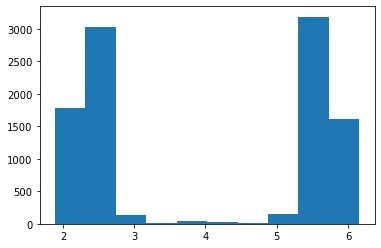

In [6]:
# define system
dim = 3
N = 2
a = 0
b = -5
c = 0.9
d0 = 4
tau = 1
system = WellSystem(dim,N,a,b,c,d0,tau)

# generate xyz trajectory
n_steps,n_trajs = 1000,10
beta,dt = 1,1e-2
x0 = np.array([[0.,0.,0.],[np.sqrt(16/3),np.sqrt(16/3),np.sqrt(16/3)]])
seed = 42
xyz = MALA_trajectories(system,n_steps,n_trajs,beta,dt,x0,seed)

# plot bond lengths
r = xyz.reshape((n_steps*n_trajs,N,dim))
r = (np.diff(r,axis = 1))**2
r = np.sqrt(np.einsum('ijk -> ij',r))

plt.hist(r.flatten())
plt.show()
plt.close()

In [7]:
# define model

class BLWellMPN(MessagePassing):
    
    def __init__(self,h_dim):
        
        super(BLWellMPN,self).__init__(aggr = 'mean')
        self.h_dim = h_dim
        
        self.lin1 = torch.nn.Linear(1,h_dim)
        self.lin2 = torch.nn.Linear(h_dim,h_dim)
        self.lin3 = torch.nn.Linear(h_dim,h_dim)
        self.lin4 = torch.nn.Linear(h_dim,h_dim)
        
    def forward(self,edge_index,x):
        
        edge_index, _ = remove_self_loops(edge_index)
        return self.propagate(edge_index = edge_index,x = x)
    
    def message(self,x_i,x_j):
        
        # compute distances
        dists = torch.sqrt(((x_i - x_j)**2).sum(dim=1,keepdim = True))
        
        # pass through nn
        h = self.lin1(dists)
        h = torch.tanh(h)
        h = self.lin2(h)
        h = torch.tanh(h)
        h = self.lin3(h)
        h = torch.tanh(h)
        #h = self.lin4(h)
        
        return h
    
    def update(self,aggr_out):
        return aggr_out
    
class VAE(torch.nn.Module):
    
    def __init__(self,hdim=128,zdim=1,xdim = 6,training = True):
        
        super(VAE,self).__init__()
        
        d1,d2,d3 = 256,256,256 # hidden dimensions in network
        self.training = training
        
        # encoder
        self.mpn = BLWellMPN(hdim)
        
        self.enc_mu = torch.nn.Linear(hdim,zdim)
        self.enc_logvar = torch.nn.Linear(hdim,zdim)
    
        # decoder
        self.dec_lin1 = torch.nn.Linear(zdim,d1)
        self.dec_lin2 = torch.nn.Linear(d1,d2)
        
        #self.dec_logvar = torch.nn.Parameter(torch.zeros(xdim), requires_grad=True)
        self.dec_logvar = torch.nn.Linear(d2,1)
        self.dec_mu = torch.nn.Linear(d2,1)
        
    def encode(self,G_batch):
        
        h = self.mpn(G_batch.edge_index,G_batch.x)
        h = global_mean_pool(h,G_batch.batch)
        
        mu_enc = self.enc_mu(h)
        logvar_enc = self.enc_logvar(h)
        
        return mu_enc, logvar_enc
    
    def reparameterize(self,mu_enc,mu_logvar):
        
        sigma = torch.exp(0.5*mu_logvar)
        eps = torch.randn_like(sigma)
        z = mu_enc + (sigma*eps)
        
        return z if self.training else mu_enc
    
    def decode(self,z):
        
        h = self.dec_lin1(z)
        h = torch.tanh(h)
        h = self.dec_lin2(h)
        h = torch.tanh(h)
        
        mu_dec = self.dec_mu(h)
        
        #batch_size = mu_dec.shape[0]
        #logvar_dec = self.dec_logvar.repeat(batch_size, 1)
        logvar_dec = self.dec_logvar(h)
        
        return mu_dec, logvar_dec
    
    def forward(self, G_batch):
        mu_enc, logvar_enc = self.encode(G_batch)
        z = self.reparameterize(mu_enc, logvar_enc)
        return self.decode(z), mu_enc, logvar_enc
    
def VAEloss(mu_dec,logvar_dec,G_batch,mu_enc,logvar_enc,L):
    
    # recon loss for p(x | z)
    pointwiseMSEloss = 0.5*torch.nn.functional.mse_loss(mu_dec,data,reduction = 'none')
    sigsq = torch.exp(logvar_dec)
    weight = 1/sigsq
    pointwiseWeightedMSEloss = pointwiseMSEloss*weight
    WeightedMSEloss = pointwiseWeightedMSEloss.sum()
    
    logvarobjective = 0.5 * logvar_dec.sum() # scaling factor term for p(x|z)
    
    # KLD loss for q(z | x)
    KLD = -0.5 * torch.sum(1 + logvar_enc - mu_enc**2 - torch.exp(logvar_enc))
    
    loss = (KLD + (1/L)*WeightedMSEloss + logvarobjective)
    
    return loss

Epoch 1 Loss: 518576975.9113426


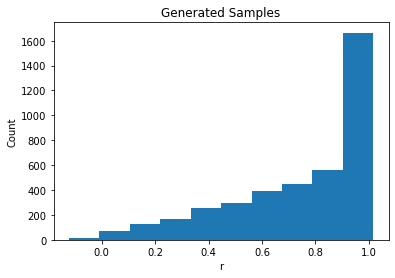

Epoch 2 Loss: 216762936.35132232


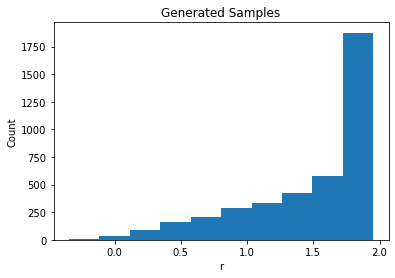

Epoch 3 Loss: 162822807.67089987


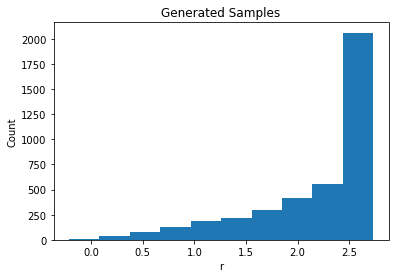

Epoch 4 Loss: 134069035.8209002


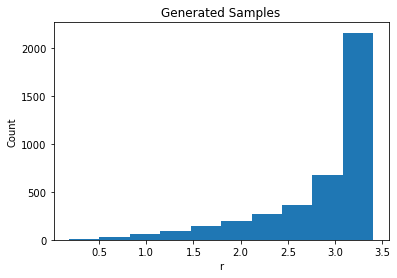

Epoch 5 Loss: 113546444.34358104


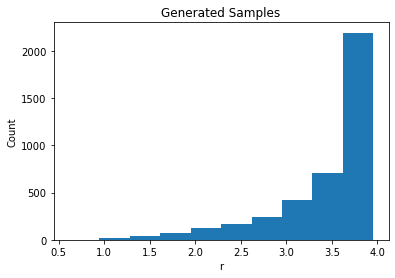

Epoch 6 Loss: 103337968.0982019


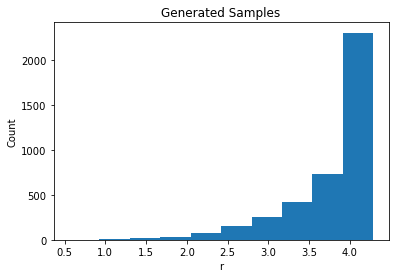

Epoch 7 Loss: 99970174.79921703


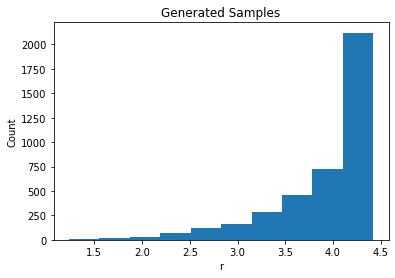

Epoch 8 Loss: 99330475.77191491


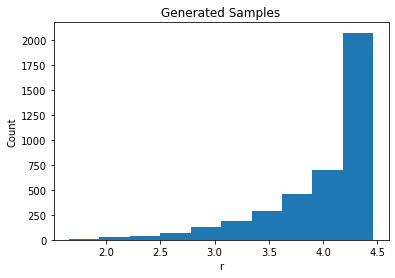

Epoch 9 Loss: 99490013.0723769


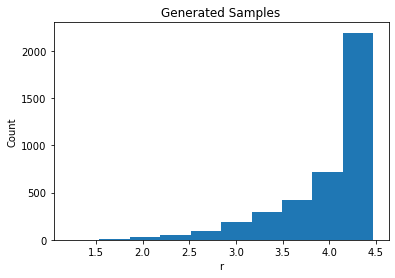

Epoch 10 Loss: 98881841.33012621


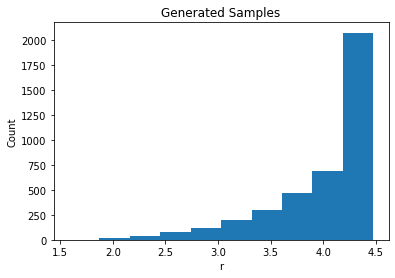

Epoch 11 Loss: 98731913.65808322


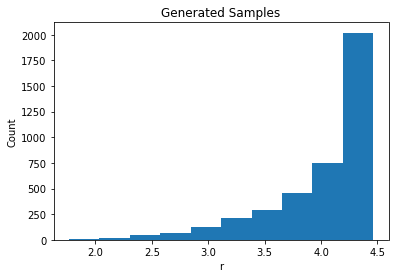

Epoch 12 Loss: 98836469.12240788


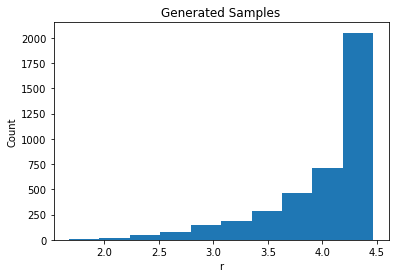

Epoch 13 Loss: 98528237.752843


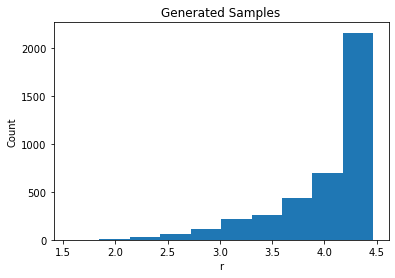

Epoch 14 Loss: 99195366.02374314


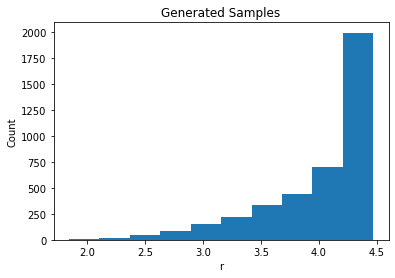

Epoch 15 Loss: 98785089.01460329


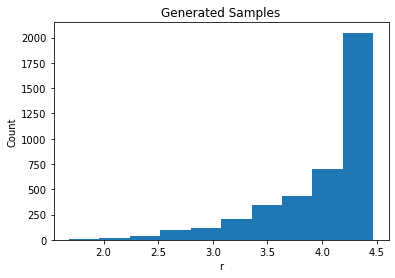

Epoch 16 Loss: 98088529.57488036


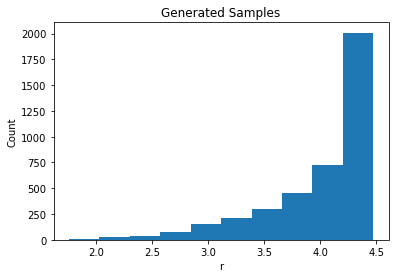

Epoch 17 Loss: 98441331.8212548


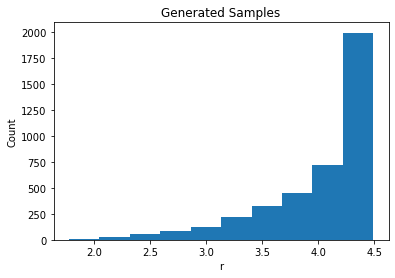

Epoch 18 Loss: 98764537.74821909


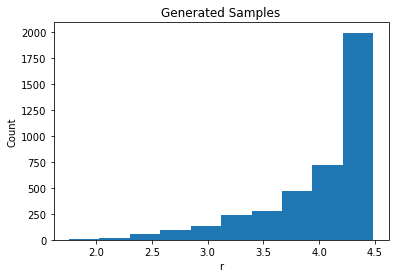

Epoch 19 Loss: 98392060.80279425


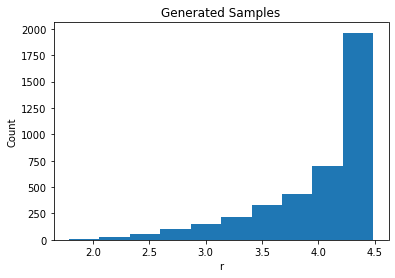

Epoch 20 Loss: 98694440.70375392


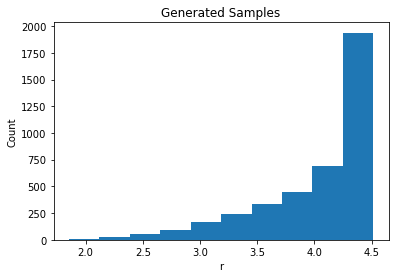

Epoch 21 Loss: 98741967.12713337


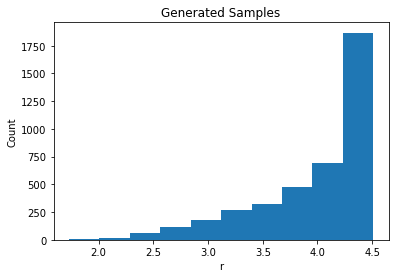

Epoch 22 Loss: 99632831.58021365


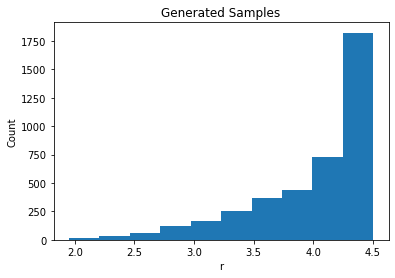

Epoch 23 Loss: 97329063.89799733


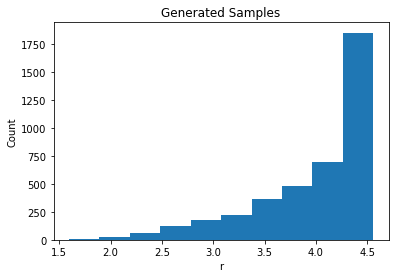

Epoch 24 Loss: 98264564.06491692


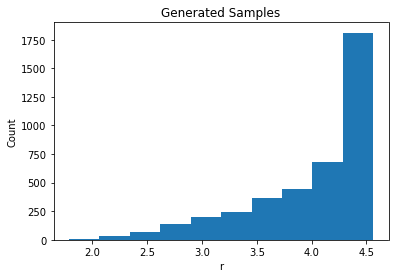

Epoch 25 Loss: 97215039.71187404


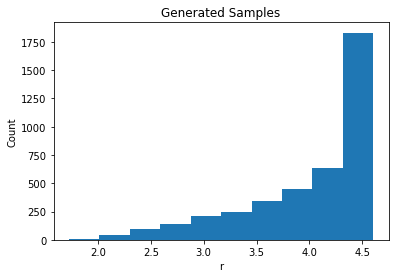

Epoch 26 Loss: 97351363.48986417


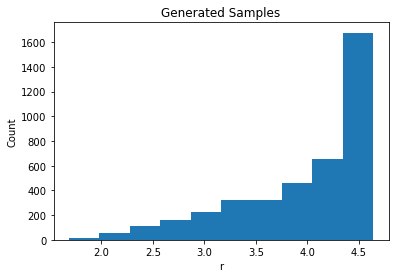

Epoch 27 Loss: 96494760.73020378


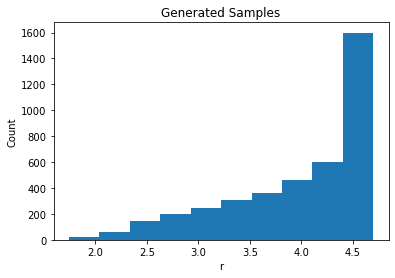

Epoch 28 Loss: 94382508.46437678


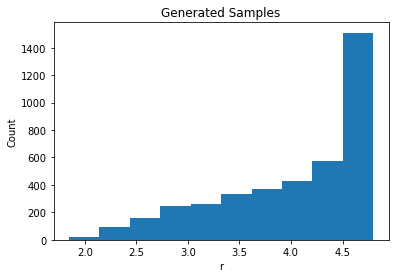

Epoch 29 Loss: 93564507.934736


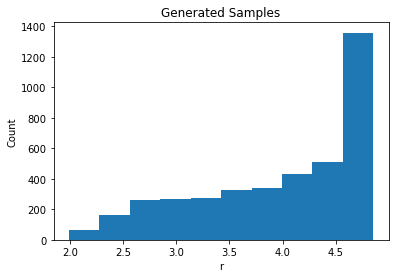

Epoch 30 Loss: 90553213.00473054


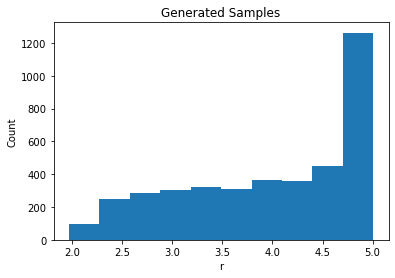

Epoch 31 Loss: 84482683.80138607


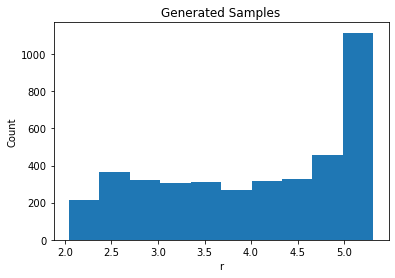

Epoch 32 Loss: 71398533.7403796


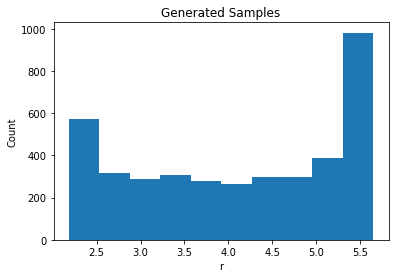

Epoch 33 Loss: 53034814.53229288


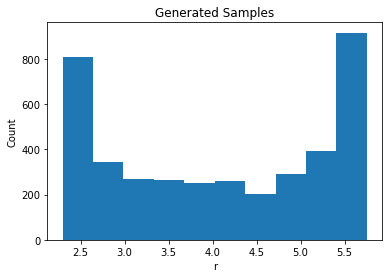

Epoch 34 Loss: 37987444.23526209


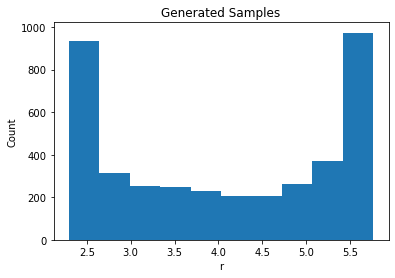

Epoch 35 Loss: 28852876.658832625


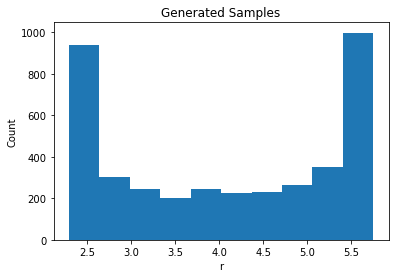

Epoch 36 Loss: 25656352.548682775


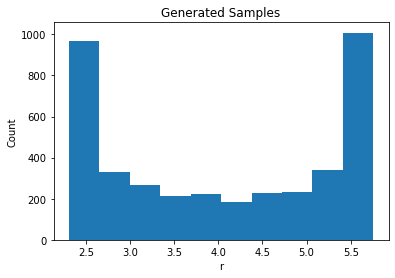

Epoch 37 Loss: 22280955.881849542


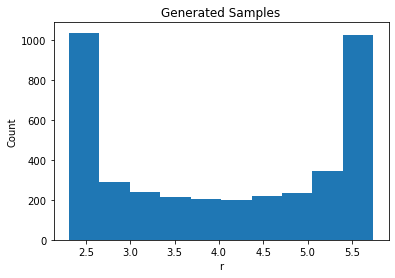

Epoch 38 Loss: 19544045.13077309


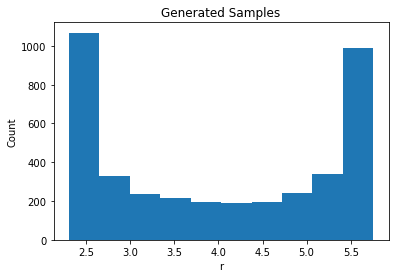

Epoch 39 Loss: 20080551.798973326


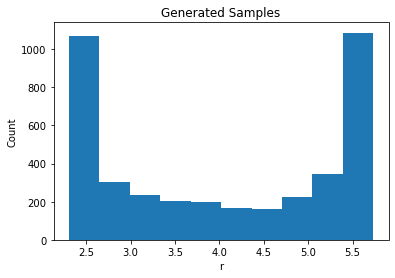

Epoch 40 Loss: 18081263.041915778


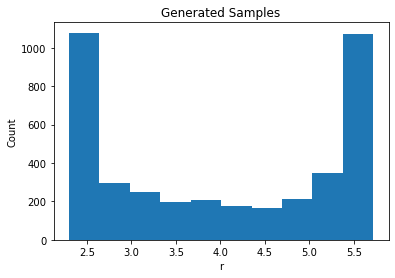

Epoch 41 Loss: 15001305.240695983


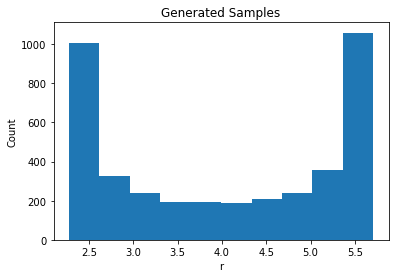

Epoch 42 Loss: 14727436.642899802


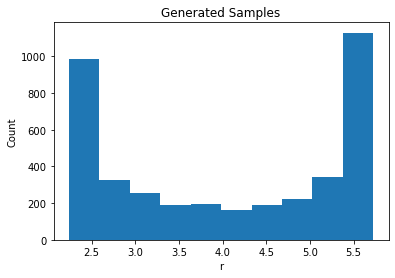

Epoch 43 Loss: 13759736.060032416


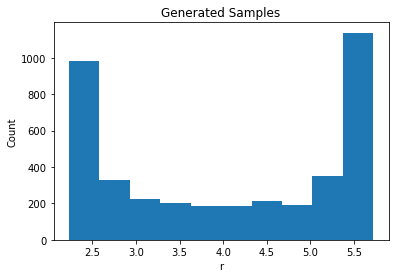

Epoch 44 Loss: 11629055.819220489


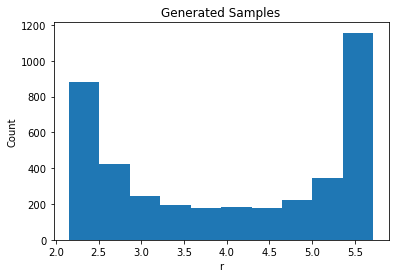

Epoch 45 Loss: 10224644.067184683


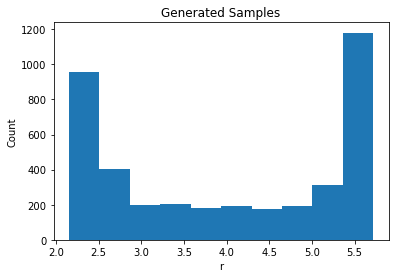

Epoch 46 Loss: 8645681.035289068


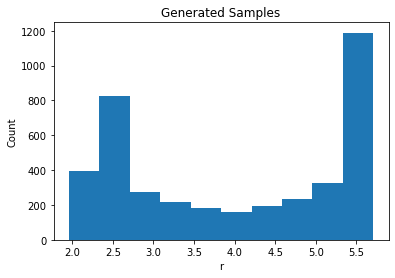

Epoch 47 Loss: 9286130.159168556


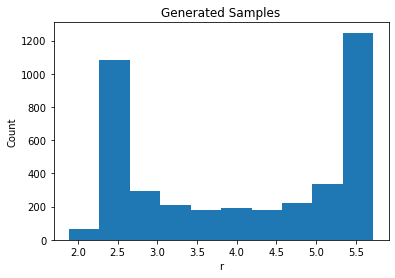

Epoch 48 Loss: 4678634.374619387


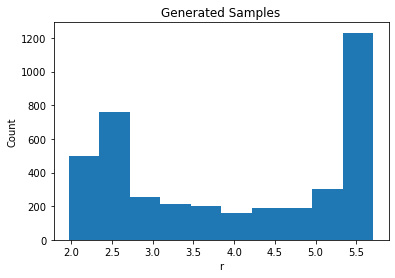

Epoch 49 Loss: 5353266.834688505


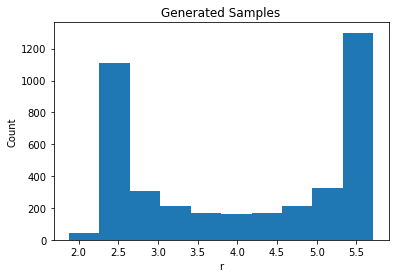

Epoch 50 Loss: 5142065.322565335


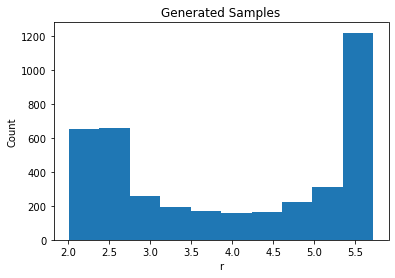

Epoch 51 Loss: 5003069.553060377


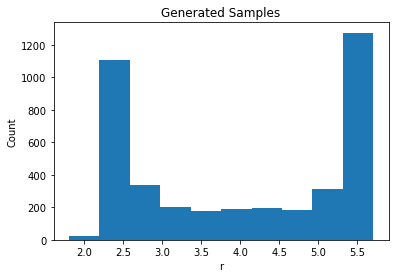

Epoch 52 Loss: 6274545.279494561


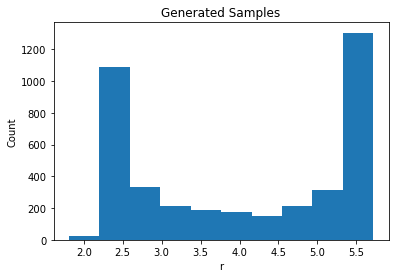

Epoch 53 Loss: 5333685.145599639


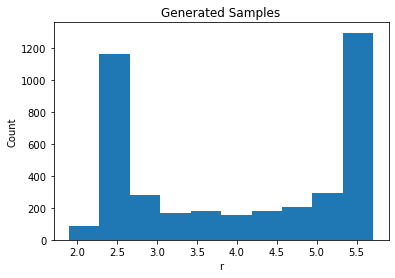

Epoch 54 Loss: 4959083.014645217


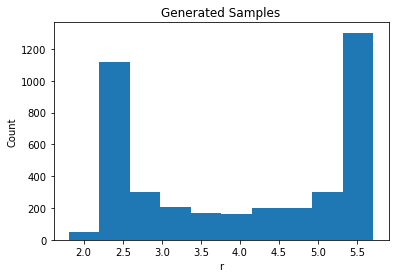

Epoch 55 Loss: 4167924.1101228036


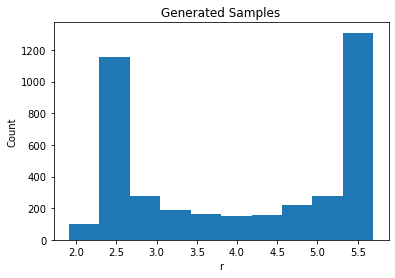

Epoch 56 Loss: 3113447.4176124088


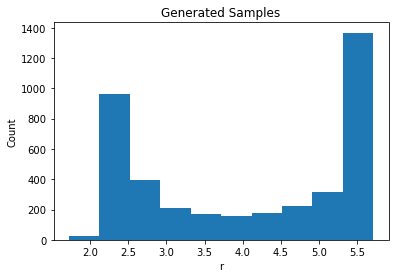

Epoch 57 Loss: 2050859.3938747756


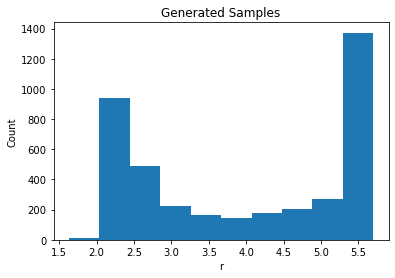

Epoch 58 Loss: 2096877.1692181048


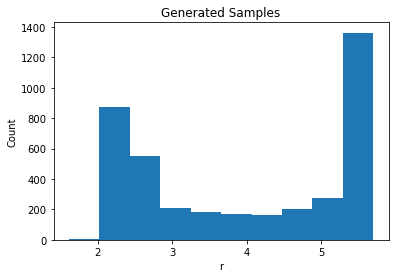

Epoch 59 Loss: 3141983.773307889


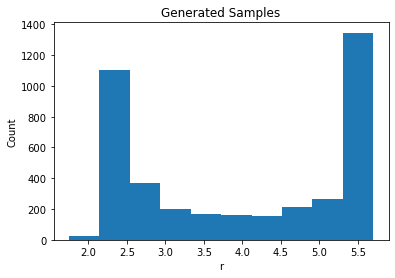

Epoch 60 Loss: 2961135.991977327


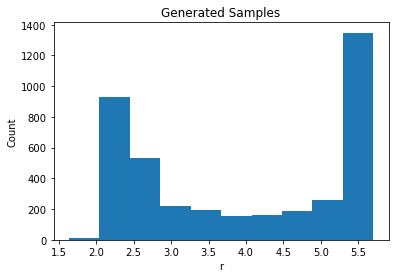

Epoch 61 Loss: 2584718.365184059


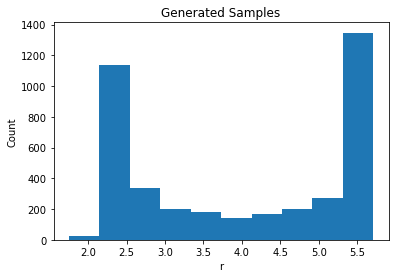

Epoch 62 Loss: 627555.7958903952


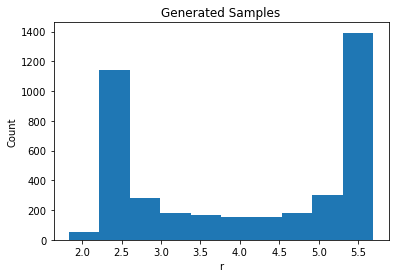

Epoch 63 Loss: 90189.94317621944


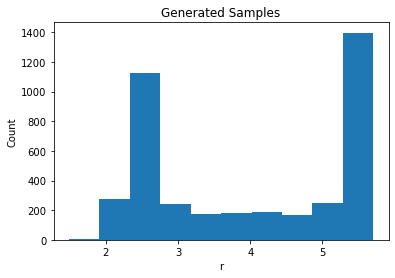

Epoch 64 Loss: -919259.1396166636


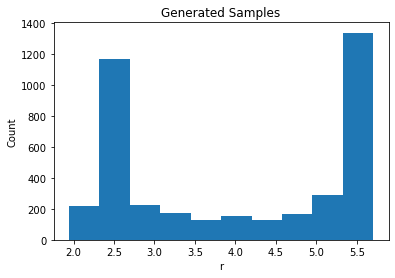

Epoch 65 Loss: 1486944.3767836916


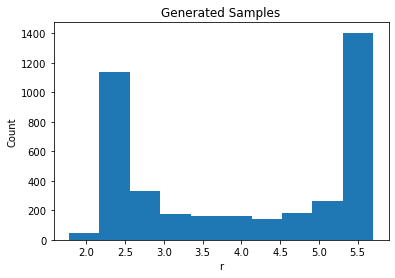

Epoch 66 Loss: 1160541.3726573624


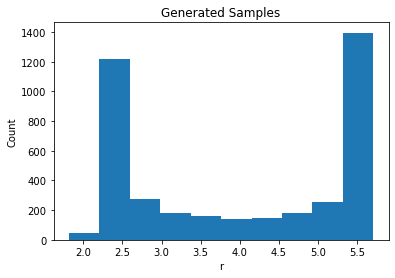

Epoch 67 Loss: 721752.2400086975


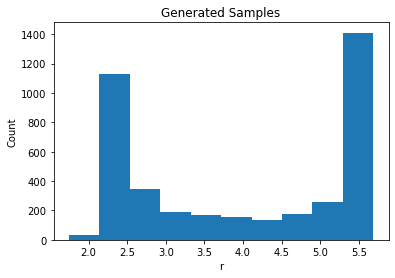

Epoch 68 Loss: 47951.26940888628


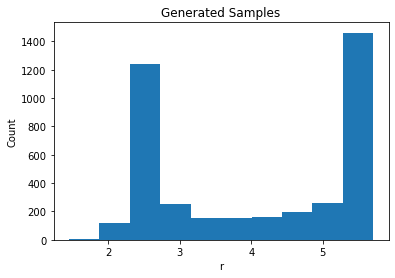

Epoch 69 Loss: -683791.3531177796


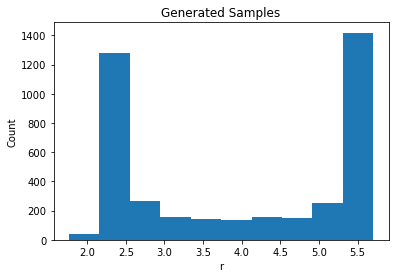

Epoch 70 Loss: -2282812.6550656813


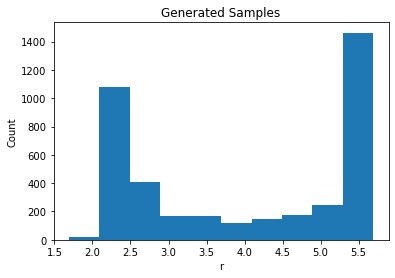

Epoch 71 Loss: -2999469.8190657212


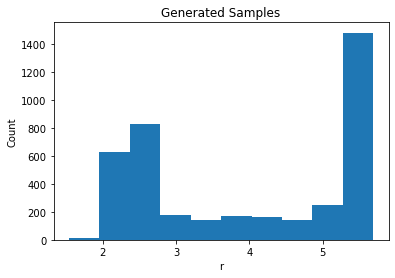

Epoch 72 Loss: -1254097.1882576596


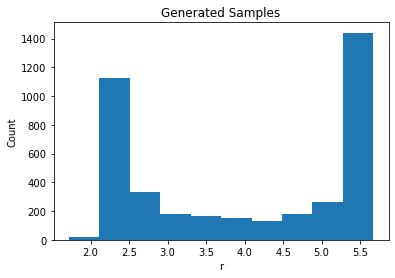

Epoch 73 Loss: -496661.20903300244


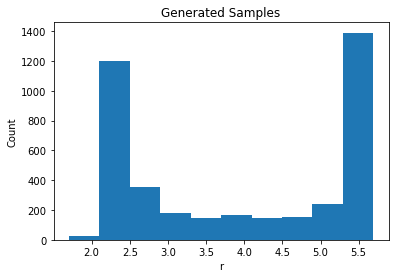

Epoch 74 Loss: -344207.2923064793


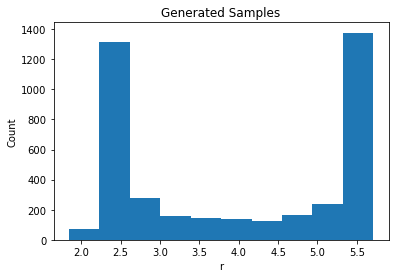

Epoch 75 Loss: 439201.9226928383


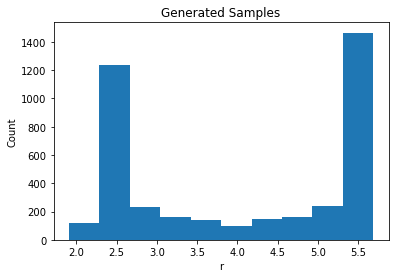

Epoch 76 Loss: -3137024.7486450286


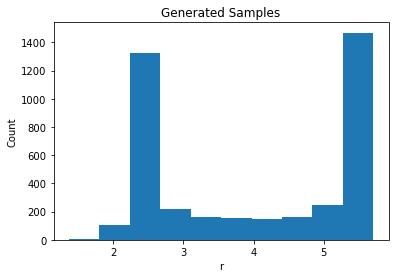

Epoch 77 Loss: -2019864.07271156


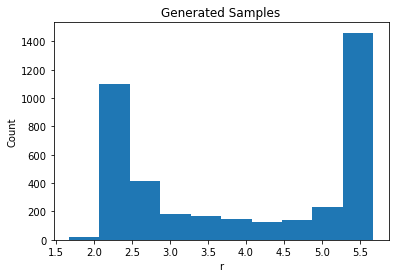

Epoch 78 Loss: -1858701.7100660556


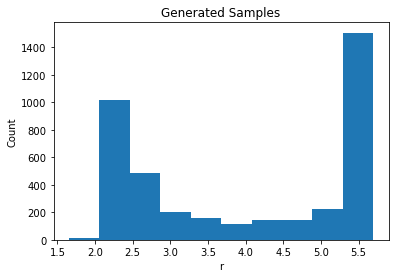

Epoch 79 Loss: -756483.5850599835


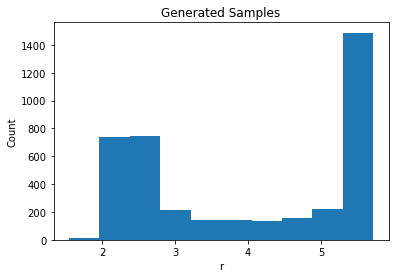

Epoch 80 Loss: -145128.49972616124


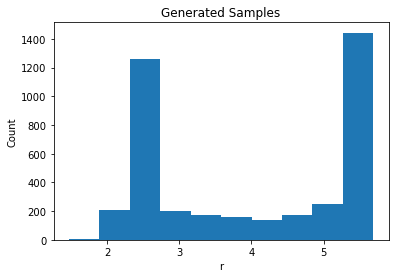

Epoch 81 Loss: -2426718.422551827


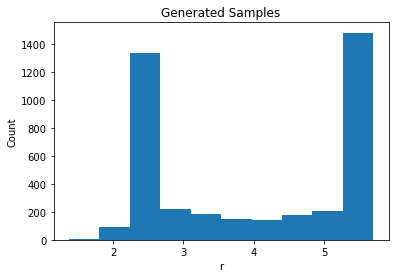

Epoch 82 Loss: -2943961.354167402


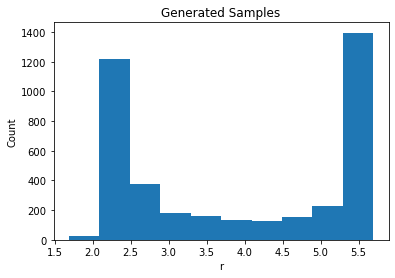

Epoch 83 Loss: -3333574.20628147


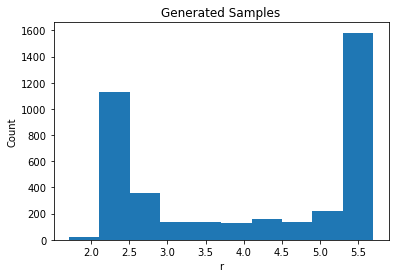

Epoch 84 Loss: 496174.44407772773


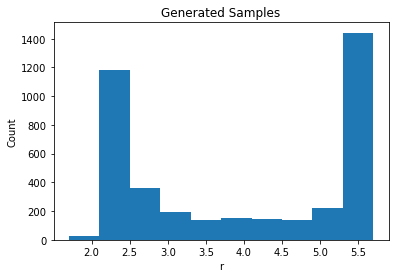

Epoch 85 Loss: -1971520.4265725384


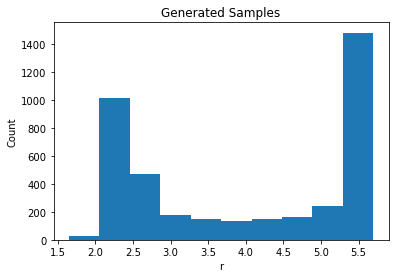

Epoch 86 Loss: -3847796.444756366


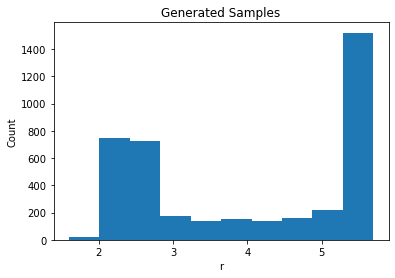

Epoch 87 Loss: -1705264.300628891


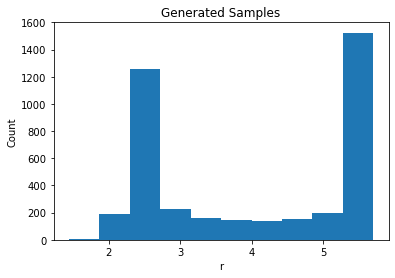

Epoch 88 Loss: -2369085.7377428524


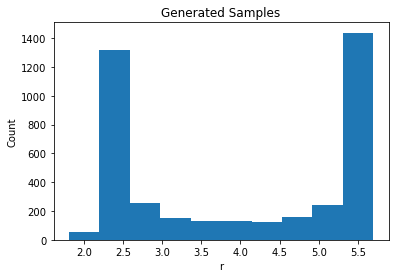

Epoch 89 Loss: -2403573.7840217208


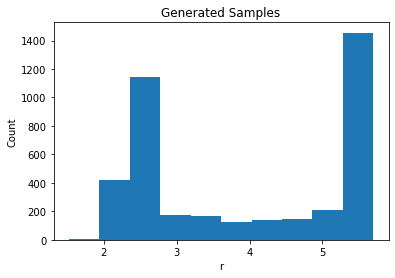

Epoch 90 Loss: -5438091.500164008


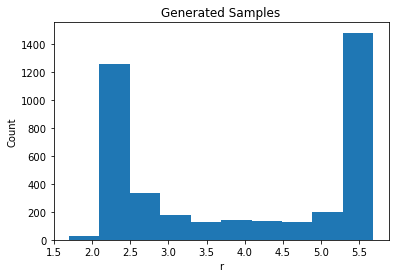

Epoch 91 Loss: -3711532.3146817354


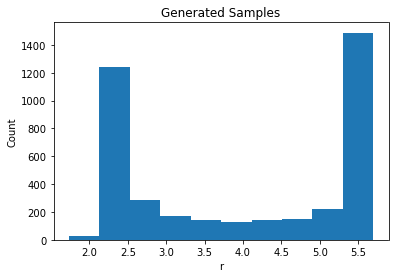

Epoch 92 Loss: -2924254.361463317


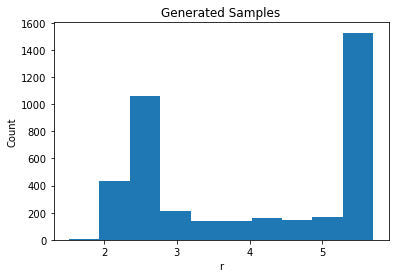

Epoch 93 Loss: -1533248.1799168417


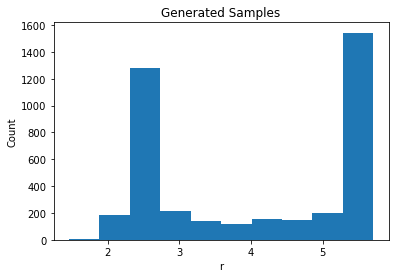

Epoch 94 Loss: -2786806.2193528186


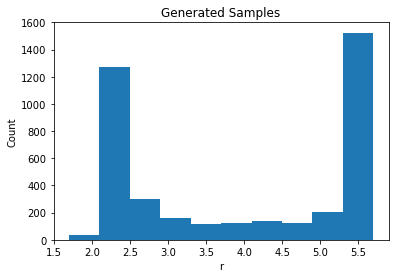

Epoch 95 Loss: -1336161.7460865562


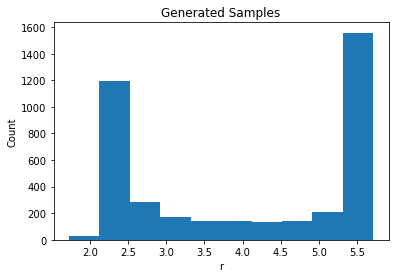

Epoch 96 Loss: -962939.6220022409


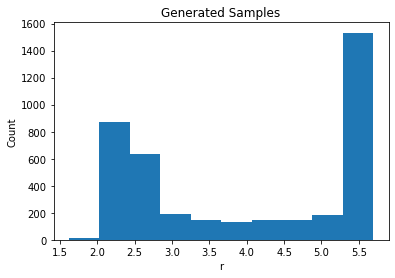

Epoch 97 Loss: -4083108.9691534117


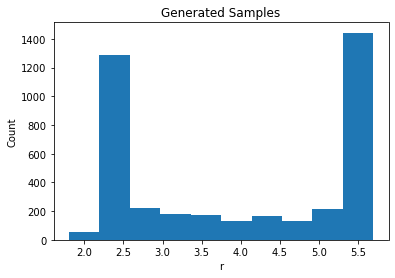

Epoch 98 Loss: -2399498.076861306


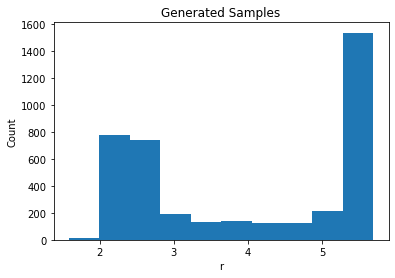

Epoch 99 Loss: -3153506.6725487965


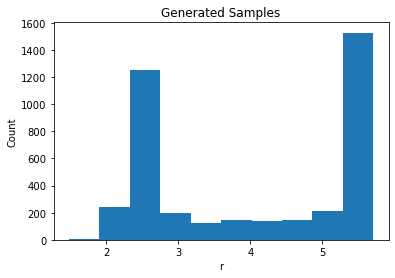

Epoch 100 Loss: -4795577.997843753


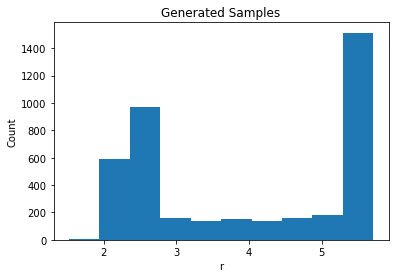

In [8]:
# build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mod = VAE()
mod = mod.double()
mod = mod.to(device)

opt = torch.optim.Adam(mod.parameters(),lr = 1e-5)
sched = ExponentialLR(opt, gamma = 0.995)

# train
epochs,batch_size = 100,32

for ep in range(epochs):
    ep_loss = 0
    
    # bootstrap sample equillibrium distribution
    np.random.seed(42)
    rand_idx = np.random.choice(n_steps*n_trajs,n_steps*n_trajs)
    traj_train= xyz[rand_idx]
    traj_train = traj_train.reshape((traj_train.shape[0],N,dim))
    
    # compute graphs
    G_traj = [MolGraph(x,V=0,dV = 0) for x in traj_train]
    loader = DataLoader(G_traj,batch_size = batch_size)
    
    for G_batch in loader:
        G_batch = G_batch.to(device)
        
        recon_batch, mu_enc, logvar_enc = mod(G_batch)
        mu_dec = recon_batch[0]
        logvar_dec = recon_batch[1]
        
        # backward pass
        # data = G_batch.x.view(int(G_batch.batch.shape[0]/N),N*dim)
        data = G_batch.x.view(int(G_batch.batch.shape[0]/N),N,dim)
        data = (data[:,0,:]-data[:,1,:])**2
        data = torch.sqrt(torch.einsum('bd -> b',data)).view(int(G_batch.batch.shape[0]/N),1)
        loss = (n_steps*n_trajs)*VAEloss(mu_dec,logvar_dec,data,mu_enc,logvar_enc,L=1)
        loss.backward()
        opt.step()
        opt.zero_grad()
        ep_loss += loss.item()
        
    print("Epoch " + str(ep + 1) + " Loss: " + str(ep_loss))
    
    # validate
    n_samps = 4000
    z = torch.randn((n_samps,1)).to(device).double()
    val_loader = DataLoader(G_traj,batch_size = n_steps*n_trajs)
    
    with torch.no_grad():
        for G in val_loader:
            enc = mod.encode(G.to(device))
        x_hat = mod.decode(z)[0]
    
    enc = enc[0].detach().cpu().numpy()
    x_hat = x_hat.detach().cpu().numpy()
    
    #r = x_hat.reshape((n_samps,N,dim))
    #r = (np.diff(r,axis = 1))**2
    #r = np.sqrt(np.einsum('ijk -> ij',r))
    
    #plt.hist(enc.flatten())
    #plt.show()
    #plt.close()
    
    plt.hist(x_hat.flatten())
    plt.title('Generated Samples')
    plt.xlabel('r')
    plt.ylabel('Count')
    plt.savefig('BLNet_recon'+str(ep+1)+'.png')
    plt.show()
    plt.close()
        